Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
from google.colab import drive
drive.mount('/content/gdrive')

data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
input_shape = (img_height, img_width, 3)

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

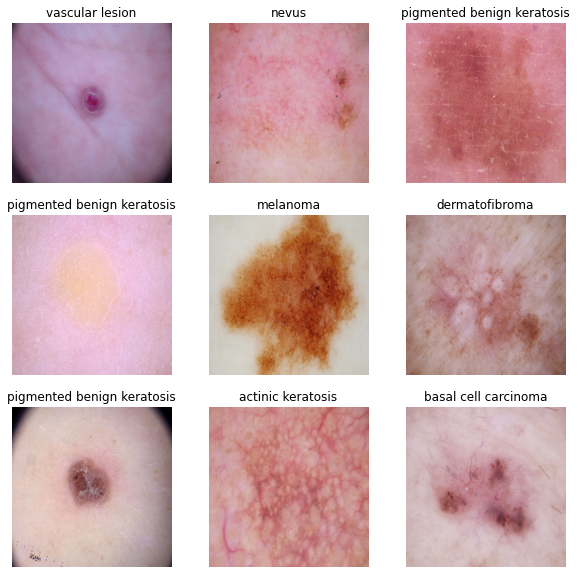

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
num_class = 9
activ = 'relu'

## Number of classes is 9
model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation=activ, input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation=activ, input_shape=input_shape),
    layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation=activ, input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation=activ),
    layers.Dense(num_class, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                      

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 308s 1s/step - loss: 1.7363 - accuracy: 0.4040 - val_loss: 2.1630 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 10s 175ms/step - loss: 1.4151 - accuracy: 0.5234 - val_loss: 2.1357 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 10s 176ms/step - loss: 1.2955 - accuracy: 0.5603 - val_loss: 2.0978 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 10s 177ms/step - loss: 1.1955 - accuracy: 0.5993 - val_loss: 2.0183 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 10s 180ms/step - loss: 1.0587 - accuracy: 0.6507 - val_loss: 1.8601 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 10s 181ms/step - loss: 0.9936 - accuracy: 0.6702 - val_loss: 1.7488 - val_accuracy: 0.5705
Epoch 8/20
56/56 [==============================] - 10s 179ms/step - loss: 0.9476 - accuracy: 0.6858 - val_loss: 1.6365 - val_accuracy: 0.5884
E

### Visualizing training results

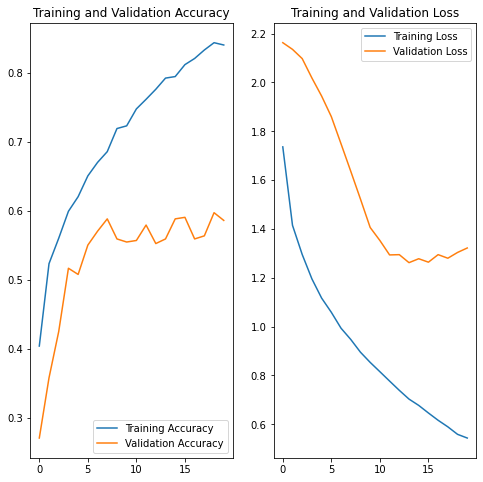

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train DataSet Accuracy: ", accuracy)
print("Validation DataSet Accuracy: ",accuracy_v)
print("Train DataSet Loss: ",loss)
print("Validation DataSet Loss", loss_v)

14/14 [==============================] - 0s 31ms/step - loss: 1.3222 - accuracy: 0.5861
Train DataSet Accuracy:  0.8381696343421936
Validation DataSet Accuracy:  0.5861297249794006
Train DataSet Loss:  0.5275807976722717
Validation DataSet Loss 1.32216215133667


### Write your findings here

From the above charts, We can see a considerable difference between training dataset accuracy and validation dataset accuracy i.e. more than 30% difference. which mean our model overfits. It is observed that after a few epochs, the validation dataset accuracy and loss are stagnant. I will now try to use dropout to get rid of overfitting.


In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_gen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = data_gen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = data_gen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


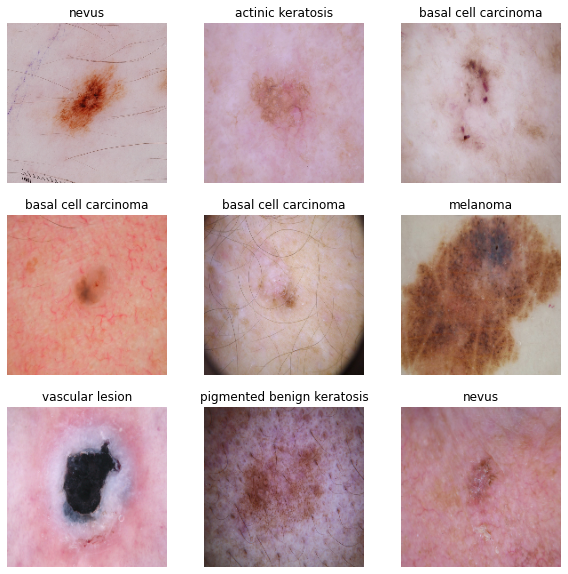

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation=activ),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation=activ),
    # Max Pool size of 2*2
    layers.MaxPool2D(pool_size=(2, 2)),
    # Adding Dropout Layer
    layers.Dropout(0.4),
    layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation=activ),
    layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation=activ),
    # Max Pool size of 2*2
    layers.MaxPool2D(pool_size=(2, 2)),
    # Adding Dropout Layer
    layers.Dropout(0.4),
    layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation=activ),
    # Max Pool size of 2*2
    layers.MaxPool2D(pool_size=(2, 2)),
    # Adding Dropout Layer
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(512, activation=activ),
    layers.Dropout(0.5),
    layers.Dense(num_class, activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Compiling the model

In [ ]:
## Your code goes here
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

### Training the model

In [ ]:
# Set a learning rate annealer
learn_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_rate_reduction]
)

Epoch 1/20
56/56 [==============================] - 7s 109ms/step - loss: 2.3779 - accuracy: 0.1998 - val_loss: 2.0521 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 1.9842 - accuracy: 0.2573 - val_loss: 1.8904 - val_accuracy: 0.3065 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 5s 97ms/step - loss: 1.8806 - accuracy: 0.3052 - val_loss: 1.7907 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 6s 99ms/step - loss: 1.7719 - accuracy: 0.3493 - val_loss: 1.9177 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 1.7393 - accuracy: 0.3622 - val_loss: 1.6751 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 1.6302 - accuracy: 0.4135 - val_loss: 1.5588 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 5s 97ms/step - loss: 1.

### Visualizing the results

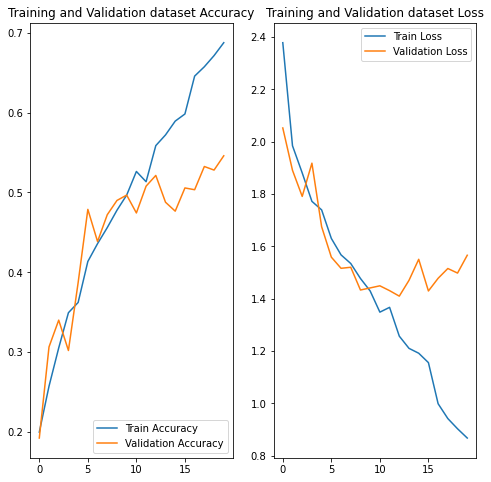

In [ ]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epoch_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, accuracy, label='Train Accuracy')
plt.plot(epoch_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation dataset Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Train Loss')
plt.plot(epoch_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation dataset Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

we can observe that there is considerable difference in the train and validation accuracy(`15%`), the difference is quite lower than our previous model. This easily states the diffrence in results that occurred due to Dropouot.

we need to investigate why there is considerable difference in accuracies. One of the reasons that this can occur is due to the class imbalance. We will further check for the class imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

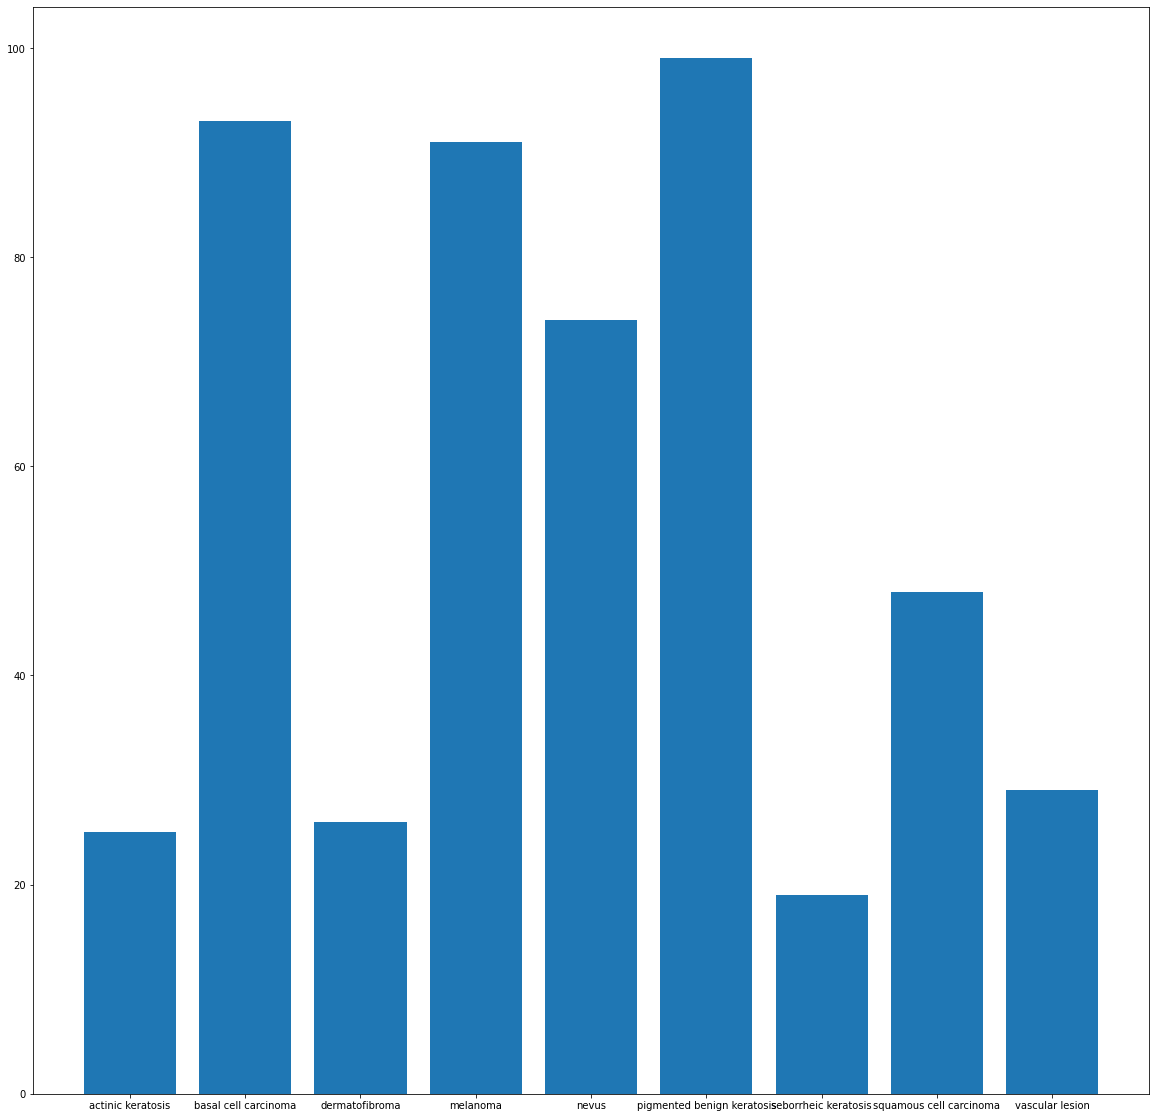

In [ ]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


We can clearly see that:

*   `seborrheic_keratosis` has the low number of samples. 
*   `pigmented_keratosis` has the high number of samples.



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset='/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32C68E7750>: 100%|██████████| 500/500 [00:19<00:00, 25.25 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32C68E4E10>: 100%|██████████| 500/500 [00:21<00:00, 23.19 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32C70604D0>: 100%|██████████| 500/500 [00:22<00:00, 22.52 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F32C6FDE1D0>: 100%|██████████| 500/500 [01:18<00:00,  6.35 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7F32C6FECA50>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32C723CC50>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F32C687E810>: 100%|██████████| 500/500 [00:40<00:00, 12.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32C68E18D0>: 100%|██████████| 500/500 [00:17<00:00, 28.32 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32C7072410>: 100%|██████████| 500/500 [00:18<00:00, 27.01 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
import os
from glob import glob
import PIL
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025831.jpg_d57e4a8a-3567-41a7-9eb5-61b7208b8f12.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_d335a651-390b-4699-afcd-afce726f3add.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030821.jpg_ef17c5c2-ff62-4623-888f-2b9b2603c3e9.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025577.jpg_f20c9232-76f0-4057-b903-9c0f7fa6a6b5.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The Intern

In [ ]:
lesion_listnew = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_listnew

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_listnew))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
new_df['Label'].value_counts()

squamous cell carcinoma       500
dermatofibroma                500
actinic keratosis             500
melanoma                      500
basal cell carcinoma          500
vascular lesion               500
pigmented benign keratosis    500
seborrheic keratosis          500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train='/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation=activ),
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation=activ),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.4),
    layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation=activ),
    layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation=activ),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.4),
    layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation=activ),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation=activ),
    layers.Dropout(0.5),
    layers.Dense(num_class, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
169/169 [==============================] - 45s 252ms/step - loss: 2.2423 - accuracy: 0.1434 - val_loss: 2.0479 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 35s 203ms/step - loss: 1.9993 - accuracy: 0.2181 - val_loss: 1.8631 - val_accuracy: 0.2457 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 34s 198ms/step - loss: 1.7169 - accuracy: 0.3379 - val_loss: 1.6370 - val_accuracy: 0.3526 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 34s 196ms/step - loss: 1.5739 - accuracy: 0.4080 - val_loss: 1.4753 - val_accuracy: 0.4477 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 37s 216ms/step - loss: 1.4735 - accuracy: 0.4445 - val_loss: 1.4217 - val_accuracy: 0.4788 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 34s 197ms/step - loss: 1.3710 - accuracy: 0.4624 - val_loss: 1.3604 - val_accuracy: 0.4811 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

#### **Todo:**  Visualize the model results

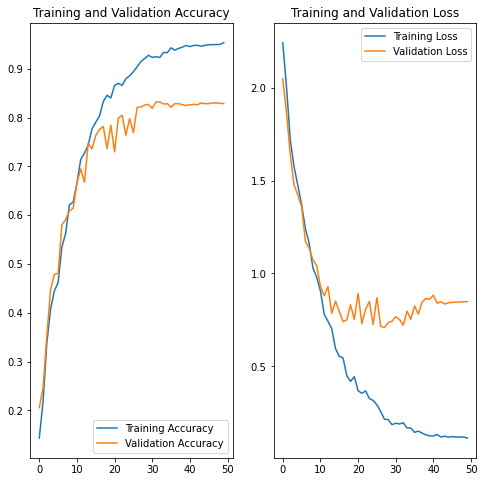

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We notice a huge difference in our results after handling the class imbalance. The overfitting of the model has been taken care of. We can still notice the difference in the training and validation accuracy but it is lesser than our previous model. We can clearly see that this model is much better than our previous model

In the end, we can conclude that dropouts and class rebalance have clearly helped us in handling over-fitting and creating a much better model.

`The End`